# Learning from data 2018 - Project 1

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|27th February 2018  | **12:00 Friday 16th March 2018** |


This workshop is worth 10% of the total module mark.

Candidate number: ** 650046686 **  

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations, if any), what the results mean, how they relate to the theory, etc. 

You can add new cells as you think fit and delete ones that are not needed (do not delete this preamble). 

### Submitting the notebooks

Only an electronic submissions is required.  Submit your notebook (the .ipynb file) to electronic copy via the  [electronic hand-in system](http://empslocal.ex.ac.uk/submit/) using the topic <cmd>2018-03-16~ECM3420~Lorenzo Livi~Project-1-clustering</cmd>.

You should be able to upload the notebook directly from wherever it is on your machine.  If you're not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out.  To keep the marking anonymous, please don't leave directory names that reveal your identity in cells.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 

## Your project starts from here!

<font color='blue'>**All of my comments in markdown cells below are written in blue to make my comments clear and stand out from the original instruction text.**</font>

In [35]:
# make sure plots are displayed correctly on notebooks
%matplotlib inline
# imports
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.datasets.samples_generator import make_blobs
from scipy.spatial.distance import euclidean

## Project specification

The project consists of two parts, each one worth 5% of the total 10% associated with this assessed workshop.

### 1. First part of the project

Implement the *k*-means algorithm using the Mahalanobis distance instead of the standard Euclidean distance.

In [36]:
def syntheticDataset(datasetSize, dimensions):
    """ Function that I can call to produce data of any size and dimension.
    
    Args:
        datasetSize: Size of dataset to be created.
        dimensions: Dimension of dataset to be created.
        
    Returns:
        A random dataset of user-defined size and dimension.
    """
    return np.random.rand(datasetSize, dimensions)


def done(centroids, oldCentroids, iterations):
    """ Function determines whether k-means is done.
    The function terminates on two occasions: (1) maximum number of iterations
    has been reached or (2) the centroids are no longer changing.
    
    Args:
        centroids: The current centroids.
        oldCentroids: The previous centroids.
        iterations: How many iteration ocurred to find optimal centroids occured so far.
        
    Returns:
        Boolean indicating whether k-means is done.
    """
    # maximum limit number of possible iterations to prevent extreme case
    if iterations > 250:
        return True
    
    counter = 0
    numCentroids = len(oldCentroids)
    
    # checks if new centroid and old centroid values are equivalent
    for n in range(numCentroids):
        # checks for preventing issues that I have come accross
        if (len(oldCentroids[n]) != 2):
            oldCentroids[n] = oldCentroids[n][0]
            
        if (len(centroids[n]) != 2):
            centroids[n] = centroids[n][0]
        
        if oldCentroids[n][0] == centroids[n][0] and oldCentroids[n][1] == centroids[n][1]:
            counter += 1
    
    # if old and new centroid values are same return true
    if counter == numCentroids and numCentroids > 0:
        return True
    
    return False

def distance(dataset, centroid, v, computeEuclid):
    """ Function that calculaties either euclidean or mahalanobis distance
    based the computeEuclid boolean parameter. I implement both for ease
    of discussion, comparison anf constrast of the final results of this
    workshop.
    
    Args:
        dataset: The dataset.
        centroid: The centroid value [x, y].
        v: The point for which we calculate the distance from the centroid value.
        computeEuclid: A boolean indiciating whether we should calculate Euclidean distance or Mahalanobis.
        
    Returns:
        Boolean indicating whether k-means is done.
    """
    # to prevent issues that I came across
    if (len(centroid) == 1):
        x = centroid[0][0]
        y = centroid[0][1]
    else:
        x = centroid[0]
        y = centroid[1]
    
    # if computing Euclidean distance
    if computeEuclid:
        return math.sqrt((x - v[0])**2 + (y - v[1])**2)
    else: # otherwise computing Mahalanobis distance
        standX = np.std(dataset[:,0])
        standY = np.std(dataset[:,1])
        return math.sqrt(((x - v[0])/standX)**2 + ((y - v[1])/standY)**2)
    
def getLabels(dataset, centroids, computeEuclid):
    """ Function the calculates the array of labels for each data point
    in the dataset.
    
    Args:
        dataset: The dataset.
        centroids: All centroid values.
        computeEuclid: A boolean indiciating whether we should calculate Euclidean distance or Mahalanobis.
        
    Returns:
        The labels for all data in dataset.
    """
    labels = []
    # iterate over all data
    for v in dataset:
        distances = []
        for centroid in centroids:
            # get distance with respect to whether we are computing Euclidean distance
            distances.append(distance(dataset, centroid, v, computeEuclid))
        # assign label to data point based on shortest distance of point to centroid
        labels.append(distances.index(min(distances)))
    return labels

def newCentroids(dataset, labels, numCentroids):
    """ Function calculates updated centroids
    to aid in obtaining best centroid values.
    
    Args:
        dataset: The dataset.
        labels: All labels for each data point in dataset.
        numCentroids: The number of centroids to be created.
        
    Returns:
        Updated array centroids.
    """
    centroids = []
    for n in range(numCentroids):
        currentInds = list(np.where(np.array(labels) == n)[0])
        numCurrentInds = len(currentInds)
        if(numCurrentInds == 0):
            # append random centroid if no centroids based on dimension of data len(dataset[1])
            newCentroids = syntheticDataset(1, len(dataset[1]))
        else:
            x = 0
            y = 0
            for i in currentInds:
                x += dataset[i][0]
                y += dataset[i][1]      
            newCentroids = [x/numCurrentInds,y/numCurrentInds]
        centroids.append(newCentroids)
    return centroids

def kmeans(dataset, numCentroids, computeEuclid):
    """ Function that find numCentroids centroids
    for a dataset, which are points that
    define clusters of data most similar
    to each other.
    
    Args:
        dataset: The dataset.
        numCentroids: number of centroids to be found.
        computeEuclid: Whether to computer k-means using Euclidean of Mahalanobis distances.
        
    Returns:
        Array of centroids and labels for each data point in the dataset for their respective centroid.
    """
    
    # iteration keeping track of how many times we looked for new centroid value
    iterations = 0
    numDimensions = len(dataset[1])
    oldCentroids = []
    centroids = syntheticDataset(numCentroids, numDimensions)
    labels = []
    
    # while loop - obtaining centroids and labels, terminated when found based on 
    # conditions detailed above
    while not done(centroids, oldCentroids, iterations):
        iterations += 1
        # assign oldCentroid value to new/previous centroids for next while loop 'done' check
        oldCentroids = centroids
        labels = getLabels(dataset, centroids, computeEuclid)
        centroids = newCentroids(dataset, labels, numCentroids)
    
    # return centroid values and labels for each data point in the data set
    return np.asarray(centroids), labels    

def plotFunction(dataSet, results):
    """ Function allows me to clearly plot and investigate the results
    gained from the kmeans function.
    
    Args:
        dataset: The dataset.
        results: The centroid and labels results of the kmeans function.
    """
    
    for key in results:
        # if have time figure how to plot each seperate cluster to its own color + unique label
        plt.scatter(dataSet[:,0], dataSet[:,1], c=results[key][1])
        plt.scatter(results[key][0][:,0], results[key][0][:,1], c="r", label="centroids")
        plt.title("Clusters Using %s Distances" %key)
        plt.legend(loc=2)
        plt.show()
        print("--------------------------------------------------------------------")
        print("Graph Analysis for", key, "Distances\n")
        print(len(dataSet),"Data Points")
        print(len(dataSet[1]), "Dimensions")
        print(len(results[key][0]), "Clusters")
        print("--------------------------------------------------------------------")
        
        clusterDataSizes = []
        for i in range(len(results[key][0])):
            numClusterDataSize = len(list(np.where(np.array(results[key][1]) == i)[0]))
            print("Cluster ", i+1, " has ", numClusterDataSize, "data points")
            clusterDataSizes.append(numClusterDataSize)

        print("The mean of data points per cluster: ", np.mean(clusterDataSizes))
        print("The maximum number of data points in a cluster:", max(clusterDataSizes))
        print("The minimum number of data points in a cluster:", min(clusterDataSizes))
        print("The standard deviation of the number of data points: ", np.std(clusterDataSizes))
        print("The variance of the number of data points: ", np.var(clusterDataSizes))
        print("--------------------------------------------------------------------")


Then, define a synthetic dataset (a 2 or 3-dimensional problem, so we can easily visualize the data, with roughly 500 data points), where *k*-means operating with Mahalanobis distance works better than *k*-means equipped with Euclidean distance and standard centroid cluster representative.</li>

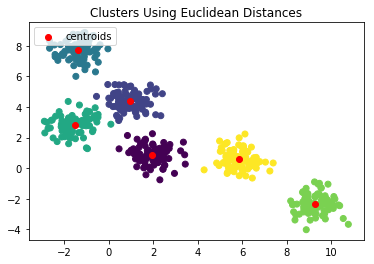

--------------------------------------------------------------------
Graph Analysis for Euclidean Distances

500 Data Points
2 Dimensions
6 Clusters
--------------------------------------------------------------------
Cluster  1  has  84 data points
Cluster  2  has  84 data points
Cluster  3  has  83 data points
Cluster  4  has  83 data points
Cluster  5  has  83 data points
Cluster  6  has  83 data points
The mean of data points per cluster:  83.3333333333
The maximum number of data points in a cluster: 84
The minimum number of data points in a cluster: 83
The standard deviation of the number of data points:  0.471404520791
The variance of the number of data points:  0.222222222222
--------------------------------------------------------------------


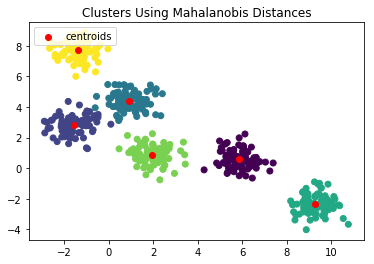

--------------------------------------------------------------------
Graph Analysis for Mahalanobis Distances

500 Data Points
2 Dimensions
6 Clusters
--------------------------------------------------------------------
Cluster  1  has  83 data points
Cluster  2  has  82 data points
Cluster  3  has  85 data points
Cluster  4  has  83 data points
Cluster  5  has  84 data points
Cluster  6  has  83 data points
The mean of data points per cluster:  83.3333333333
The maximum number of data points in a cluster: 85
The minimum number of data points in a cluster: 82
The standard deviation of the number of data points:  0.942809041582
The variance of the number of data points:  0.888888888889
--------------------------------------------------------------------


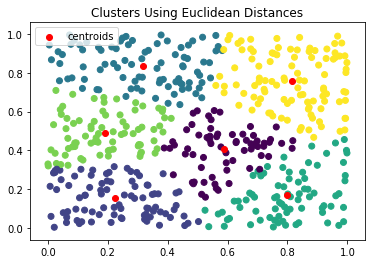

--------------------------------------------------------------------
Graph Analysis for Euclidean Distances

500 Data Points
4 Dimensions
6 Clusters
--------------------------------------------------------------------
Cluster  1  has  68 data points
Cluster  2  has  86 data points
Cluster  3  has  87 data points
Cluster  4  has  79 data points
Cluster  5  has  77 data points
Cluster  6  has  103 data points
The mean of data points per cluster:  83.3333333333
The maximum number of data points in a cluster: 103
The minimum number of data points in a cluster: 68
The standard deviation of the number of data points:  10.8115164935
The variance of the number of data points:  116.888888889
--------------------------------------------------------------------


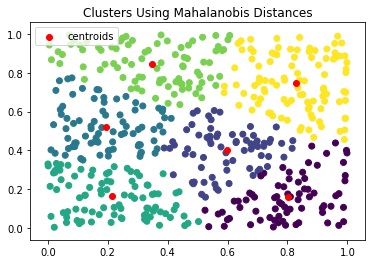

--------------------------------------------------------------------
Graph Analysis for Mahalanobis Distances

500 Data Points
4 Dimensions
6 Clusters
--------------------------------------------------------------------
Cluster  1  has  74 data points
Cluster  2  has  72 data points
Cluster  3  has  79 data points
Cluster  4  has  91 data points
Cluster  5  has  85 data points
Cluster  6  has  99 data points
The mean of data points per cluster:  83.3333333333
The maximum number of data points in a cluster: 99
The minimum number of data points in a cluster: 72
The standard deviation of the number of data points:  9.49853789918
The variance of the number of data points:  90.2222222222
--------------------------------------------------------------------


In [62]:
numCentroids = 6
dataInvestigate = []

X, y = make_blobs(n_samples=500, centers=numCentroids, cluster_std=0.60, random_state=0)

dataInvestigate.append(X)
dataInvestigate.append(syntheticDataset(500, 4))

for i in dataInvestigate:
    results = {}
    
    euclideanCentroids, euclideanLabels = kmeans(i, numCentroids, True)
    results["Euclidean"] = [euclideanCentroids, euclideanLabels]

    mahalanobisCentroids, mahalanobisLabels = kmeans(i, numCentroids, False)
    results["Mahalanobis"] = [mahalanobisCentroids, mahalanobisLabels]
    
    plotFunction(i, results)

### Discussion
<font color="blue">
<br>
It is evident from multiple tests with different datasets (only two displayed above), that there exists best choice for distance measure for a certain dataset. Different methods for measuring distances between optimal centroids and the points in a dataset will inevitably alter the resulting clustering. Therefore, chosing a specific method should depend on a the dataset and on the purpose of the project, carefully assessing which distance measure is most 
<br><br>
From my personal observation, the use of Mahalanobis distance measure can be leveraged depending on natural groupings (clusters) in the dataset. The decision to apply Mahalanobis over Euclidean distance in k-means is actually a choice of using  or not using the full-covariance of the data clusters, respectively. We assume that clusters have identity covariances when using Euclidean distance. In 2D, this means that your clusters have circular shapes. It is evident that if the covariances of the natural groupings of data in a dataset are not identity matrices (such as in two dimensional data), clusters will have elliptical shaped covariances. In such case, using Mahalanobis distance rather than Euclidean is much more appropriate for modeling.
<br><br>
I have proved my observation by testing multiple datasets. It is also important to note that which distance method is used largely depends on the purpose of the project and what is done after clustering, since clusteing itself is most of the time only a part of a larger project objective, so it will be followed by more processing. Therefore, the decision to chose either distance method could easily be determined by the performance of Mahalanobis vs Euclidean distance in subsequent performance processing.
</font>

### 2. Second part of the project

Implement the Davies-Bouldin index for cluster validation (intrinsic cluster validation).

<font color = "blue"> Using Davies-Bould criterion: </font>

  \begin{align*}
    \text{DB}(\mathcal{C}) = \frac{1}{k} \sum_{i=1}^k   \max_{j \leq k, j \neq i} D_{ij},  k = |\mathcal{C}|
  \end{align*}

In [63]:
def DaviesBouldinValidation(X, labels, centroids):
    
    """ Function that calculates the Davies-Bouldin criterion
    value in relation to the X dataset and numClusters
    clusters as defined by the parameters.
    
    Args:
        X: The dataset.
        numClusters: Number of clusters for data.
        
    Returns:
        The resulting Davies-Bouldin criterion value.
    """
    
    # get number of clusters
    binCluster = len(np.bincount(labels))
    
    # array holding cluster values
    clusters = [[] for i in range(binCluster)]
    for ind, val in enumerate(X):
        clusters[labels[ind]].append(val)
 
    # calculate mean euclidean distance for all centroids and their respective data points
    distances = [np.mean([euclidean(l, centroids[i]) for l in m]) for i, m in enumerate(clusters)]
    
    dbResults = []
    
    # calculating the davies bouldin criterion value based on formula defined above
    for i in range(binCluster):
        dbTemporary = []
        for j in range(binCluster):
            if j != i:
                # append davies-boulding criterion value
                dbTemporary.append((distances[i] + distances[j]) / euclidean(centroids[i], centroids[j]))
        dbResults.append(max(dbTemporary))
    return(sum(dbResults) / binCluster)

Perform model selection for selecting *k* of *k*-means (use the standard implementation with Euclidean distances and centroids) on the synthetic dataset named "cluster_validation_data" that can be downloaded from the module web page.

### Discussion for the results below
<font color="blue">
The Davies–Bouldin index is the mean of all clusters, therefore a good method for chosing the number of clusters to actually have for given data is to plot the Davies-Bouldin index over the number of clusters that it is calculated for, as we have done above. The number of clusters for which the index value is the lowest provides a good indication for how many clusters we should use for our dataset; in other words, the number of clusters that we could most ideally classify our data into. We have applied this method below for testing a range of k values and finding the ideal number of clusters (the k value) in the k-means algorithm, where the number of ideal clusters is not known prior to observing the pattern of the resulting plot. It is evident that the relationship is such that the Davies-Bouldin criterion value increases as the number of clusters increases for 2	=< k <= 10; it is an directly proportional relationship for the defined k values, which was expected. 

array([[  2.        ,   0.466349  ],
       [  3.        ,   0.44543641],
       [  4.        ,   0.85816209],
       [  5.        ,   1.11201214],
       [  6.        ,   0.94071016],
       [  7.        ,   0.97497403],
       [  8.        ,   0.85954914],
       [  9.        ,   0.86821833],
       [ 10.        ,   0.86053294],
       [ 11.        ,   0.89416446],
       [ 12.        ,   0.90334584],
       [ 13.        ,   0.84446687],
       [ 14.        ,   0.89711147],
       [ 15.        ,   0.84444143],
       [ 16.        ,   0.92765983],
       [ 17.        ,   0.82915319],
       [ 18.        ,   0.8923552 ],
       [ 19.        ,   0.81518529],
       [ 20.        ,   0.77860682],
       [ 21.        ,   0.80049571],
       [ 22.        ,   0.79634213],
       [ 23.        ,   0.81151015],
       [ 24.        ,   0.78830568],
       [ 25.        ,   0.78262912],
       [ 26.        ,   0.81937207],
       [ 27.        ,   0.77302781],
       [ 28.        ,   0.80957002],
 

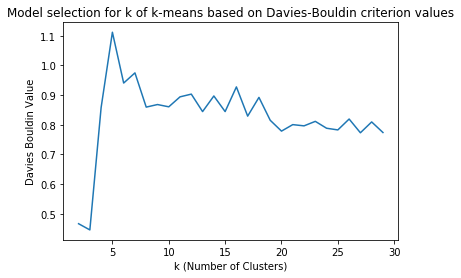

In [75]:
import scipy.optimize
data = np.loadtxt("cluster_validation_data", delimiter=",")

def modelSelection(X=data):
    DBresults = []
    for i in range(2, 30): 
        centroids, labels = kmeans(X, i, True)
        DBresults.append([i, DaviesBouldinValidation(data, labels, centroids)])
    DBresults = np.array(DBresults)
    plt.plot(DBresults[:,0], DBresults[:,1])
    plt.title("Model selection for k of k-means based on Davies-Bouldin criterion values")
    plt.xlabel('k (Number of Clusters)')
    plt.ylabel('Davies Bouldin Value')
    plt.show
    return DBresults
        
modelSelection()